# Predict Customer Lifetime

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
import shap

from lifelines import ExponentialFitter, GeneralizedGammaRegressionFitter
from lifelines import WeibullFitter, LogNormalFitter, LogLogisticFitter
from lifelines import LogNormalAFTFitter, LogLogisticAFTFitter, WeibullAFTFitter, CoxPHFitter

from lifelines.utils import concordance_index
from lifelines.plotting import qq_plot
from lifelines.utils import find_best_parametric_model

# import custom data class
from data.processing.processing import ChurnDataset

d:\anaconda3\envs\cbm_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# import churn dataset
data = ChurnDataset()
data.load_data()
# prepare dataset
data.prep_total_charges()
data.encode_numeric_features()
data.encode_categorical_features()
data.add_tenure_epsilon(epsilon=0.001)
# get prepared datasets
tenure_df = data.get_data()

In [3]:
tenure_df.head(3)

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes
0,0,1.001,29,29,0,1,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0
1,0,34.001,56,1889,1,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
2,0,2.001,53,108,1,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,1


In [4]:
tenure_df.dtypes

SeniorCitizen                              int32
tenure                                   float64
MonthlyCharges                             int32
TotalCharges                               int32
gender_Male                                uint8
Partner_Yes                                uint8
Dependents_Yes                             uint8
PhoneService_Yes                           uint8
MultipleLines_No phone service             uint8
MultipleLines_Yes                          uint8
InternetService_Fiber optic                uint8
InternetService_No                         uint8
OnlineSecurity_No internet service         uint8
OnlineSecurity_Yes                         uint8
OnlineBackup_No internet service           uint8
OnlineBackup_Yes                           uint8
DeviceProtection_No internet service       uint8
DeviceProtection_Yes                       uint8
TechSupport_No internet service            uint8
TechSupport_Yes                            uint8
StreamingTV_No inter

In [5]:
tenure_df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,...,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.372149,64.295897,2282.830754,0.504756,0.483033,0.299588,0.903166,0.096834,0.421837,...,0.384353,0.216669,0.387903,0.209144,0.240664,0.592219,0.216101,0.335794,0.228880,0.265370
std,0.368612,24.559481,30.092727,2264.997388,0.500013,0.499748,0.458110,0.295752,0.295752,0.493888,...,0.486477,0.412004,0.487307,0.406726,0.427517,0.491457,0.411613,0.472301,0.420141,0.441561
min,0.000000,0.001000,18.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,9.001000,35.000000,401.500000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,29.001000,70.000000,1400.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,55.001000,89.000000,3786.500000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,1.000000,72.001000,118.000000,8684.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Exploratory Data Analysis

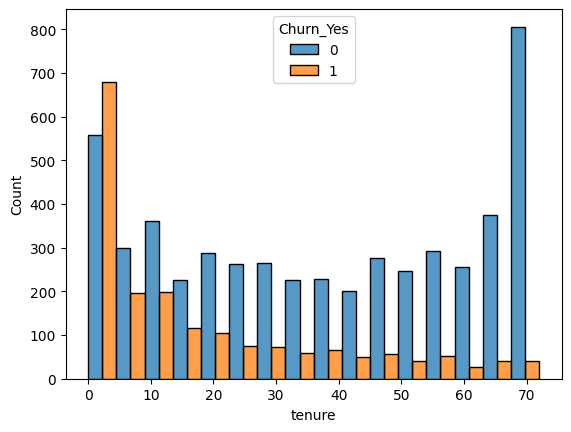

In [6]:
sns.histplot(
    data=tenure_df,
    x='tenure',
    hue='Churn_Yes',
    multiple='dodge')
plt.show()

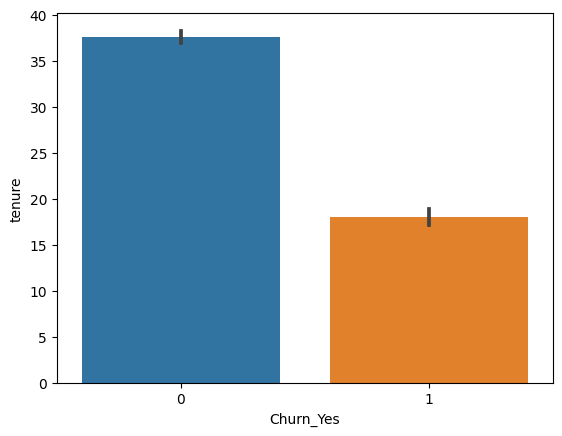

In [7]:
sns.barplot(
    data = tenure_df,
    y = 'tenure',
    x = 'Churn_Yes'   
)
plt.show()

# Train-Test Split

In [8]:
tenure_df_train, tenure_df_test = train_test_split(tenure_df, test_size=0.33, random_state=123)

In [9]:
tenure_df_train.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes
3105,0,26.001,49,1237,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5195,0,72.001,75,5336,1,0,0,1,0,0,...,1,0,0,0,1,1,0,0,0,0
5748,0,21.001,99,1992,0,0,0,1,0,1,...,1,0,1,0,0,1,1,0,0,0
6988,0,23.001,69,1652,0,1,1,1,0,1,...,1,0,0,0,0,1,1,0,0,0
6523,0,15.001,45,693,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0


In [10]:
tenure_df_test.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes
941,0,13.001,30,382,0,0,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1404,0,35.001,23,797,0,0,0,1,0,1,...,0,1,0,0,1,0,0,0,0,0
5515,0,18.001,19,309,0,1,1,1,0,0,...,0,1,0,0,1,0,0,0,1,0
3684,0,43.001,75,3161,1,0,0,1,0,1,...,0,0,0,0,0,1,1,0,0,0
7017,0,51.001,20,1020,0,0,0,1,0,0,...,0,1,0,0,1,0,0,0,0,0


# Modeling 
## Regression Model for Lifetime Prediction (i.e. Tenure)

First let´s do "classical" machine learning the estimate the tenure values in the datasets of churners i.e. the uncensored data on which we can train a standard regression model

In [11]:
# get uncensored churn data to train regression model on
has_churned_train = tenure_df_train[tenure_df_train['Churn_Yes'] == 1]
has_churned_test = tenure_df_test[tenure_df_test['Churn_Yes'] == 1]

has_churned_train.head(3)

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes
4556,0,2.001,67,116,1,0,0,1,0,0,...,0,0,0,0,0,1,0,1,0,1
2589,1,3.001,76,231,1,0,0,1,0,1,...,0,0,0,0,0,1,0,1,0,1
6813,0,64.001,47,3147,0,1,0,0,1,0,...,0,0,1,0,1,0,0,1,0,1


In [12]:
features = has_churned_train.columns.to_list()
features.remove('TotalCharges') # this is leakage b/c its not known before churn
features.remove('Churn_Yes')
features.remove('tenure')
features

['SeniorCitizen',
 'MonthlyCharges',
 'gender_Male',
 'Partner_Yes',
 'Dependents_Yes',
 'PhoneService_Yes',
 'MultipleLines_No phone service',
 'MultipleLines_Yes',
 'InternetService_Fiber optic',
 'InternetService_No',
 'OnlineSecurity_No internet service',
 'OnlineSecurity_Yes',
 'OnlineBackup_No internet service',
 'OnlineBackup_Yes',
 'DeviceProtection_No internet service',
 'DeviceProtection_Yes',
 'TechSupport_No internet service',
 'TechSupport_Yes',
 'StreamingTV_No internet service',
 'StreamingTV_Yes',
 'StreamingMovies_No internet service',
 'StreamingMovies_Yes',
 'Contract_One year',
 'Contract_Two year',
 'PaperlessBilling_Yes',
 'PaymentMethod_Credit card (automatic)',
 'PaymentMethod_Electronic check',
 'PaymentMethod_Mailed check']

In [13]:
X_train = has_churned_train[features]
y_train = has_churned_train['tenure'].values

In [14]:
X_test = has_churned_test[features]
y_test = has_churned_test['tenure'].values

In [15]:
y_train.shape

(1227,)

In [16]:
y_test.shape

(642,)

In [17]:
reg = GradientBoostingRegressor(random_state=123)
reg.fit(X_train, y_train)

GradientBoostingRegressor(random_state=123)

In [18]:
# r2 score on training set
r2_score(y_train, reg.predict(X_train))

0.6581366735491804

In [19]:
# r2 score on test set
r2_score(y_test, reg.predict(X_test))

0.543751791865825

In [20]:
# concordance index on training set
concordance_index(event_times=y_train, predicted_scores=reg.predict(X_train))

0.7964286620772899

In [21]:
# concordance index on test set
concordance_index(event_times=y_test, predicted_scores=reg.predict(X_test))

0.7666319546982908

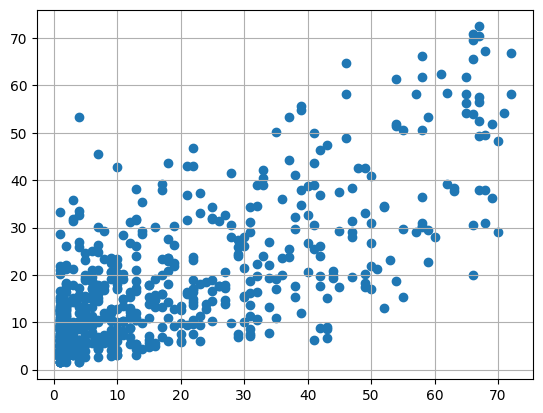

In [22]:
plt.scatter(
    x=y_test,
    y=reg.predict(X_test)
)
plt.grid()

## Feature Importance

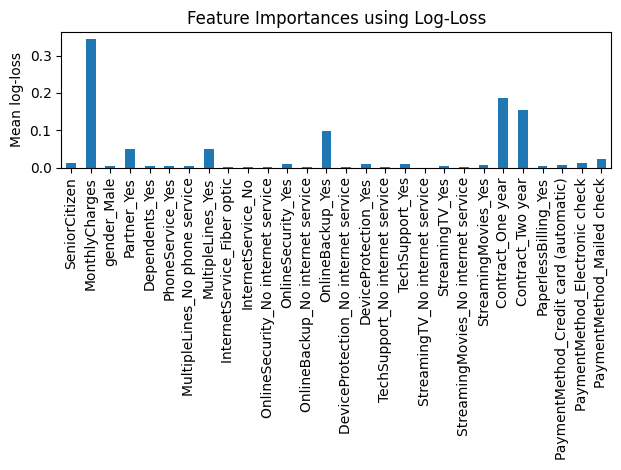

In [23]:
importances = reg.feature_importances_
forest_importances = pd.Series(importances, index=features)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature Importances using Log-Loss")
ax.set_ylabel("Mean log-loss")
fig.tight_layout()

## Conclusion
We cannot robustly predict tenure i.e. the number of month a customer will stay before churning beforehand; Let´s try to predict churn itself

## Classification Model for Churn-Prediction

In [24]:
features = tenure_df_train.columns.to_list()
features.remove('Churn_Yes')
features

['SeniorCitizen',
 'tenure',
 'MonthlyCharges',
 'TotalCharges',
 'gender_Male',
 'Partner_Yes',
 'Dependents_Yes',
 'PhoneService_Yes',
 'MultipleLines_No phone service',
 'MultipleLines_Yes',
 'InternetService_Fiber optic',
 'InternetService_No',
 'OnlineSecurity_No internet service',
 'OnlineSecurity_Yes',
 'OnlineBackup_No internet service',
 'OnlineBackup_Yes',
 'DeviceProtection_No internet service',
 'DeviceProtection_Yes',
 'TechSupport_No internet service',
 'TechSupport_Yes',
 'StreamingTV_No internet service',
 'StreamingTV_Yes',
 'StreamingMovies_No internet service',
 'StreamingMovies_Yes',
 'Contract_One year',
 'Contract_Two year',
 'PaperlessBilling_Yes',
 'PaymentMethod_Credit card (automatic)',
 'PaymentMethod_Electronic check',
 'PaymentMethod_Mailed check']

In [25]:
X_train =  tenure_df_train[features]
y_train =  tenure_df_train['Churn_Yes'].values

In [26]:
X_test =  tenure_df_test[features]
y_test =  tenure_df_test['Churn_Yes'].values

In [27]:
clf = GradientBoostingClassifier(random_state=123)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [28]:
# accuracy score on training set
clf.score(X_train, y_train)

0.8281051292920729

In [29]:
# accuracy score on test set
clf.score(X_test, y_test)

0.7982795698924732

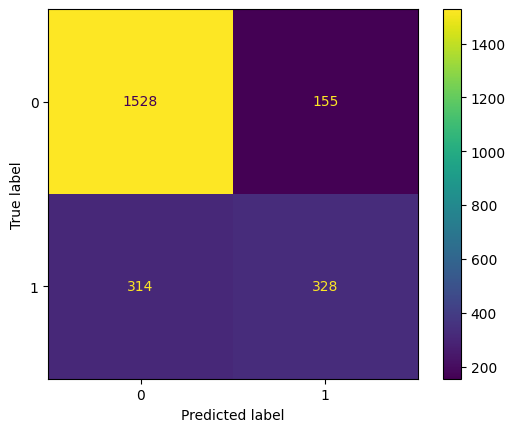

In [30]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

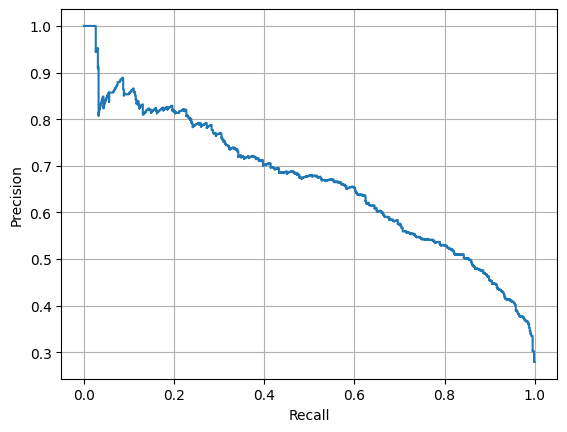

In [31]:
# precision recall curve
y_score = clf.decision_function(X_test)
prec, recall, _ = precision_recall_curve(y_test, y_score, pos_label=clf.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()
plt.grid()

## Feature Importance

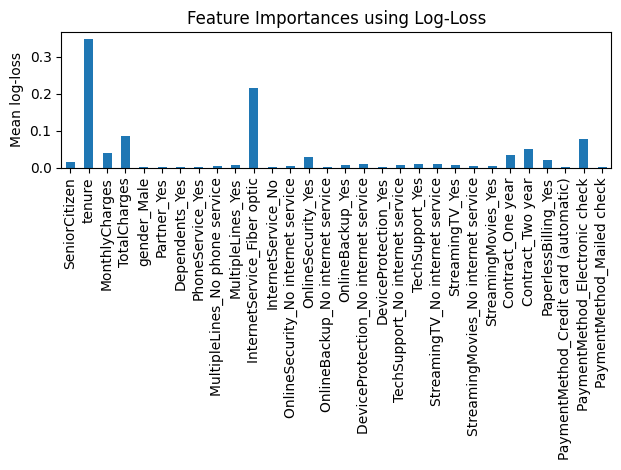

In [32]:
importances = clf.feature_importances_
forest_importances = pd.Series(importances, index=features)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature Importances using Log-Loss")
ax.set_ylabel("Mean log-loss")
fig.tight_layout()

In [33]:
explainer = shap.TreeExplainer(
    model=clf,
    data = X_test, 
    feature_perturbation = "interventional",
    model_output='probability')

In [34]:
shap_values = explainer.shap_values(X_test, check_additivity=True)

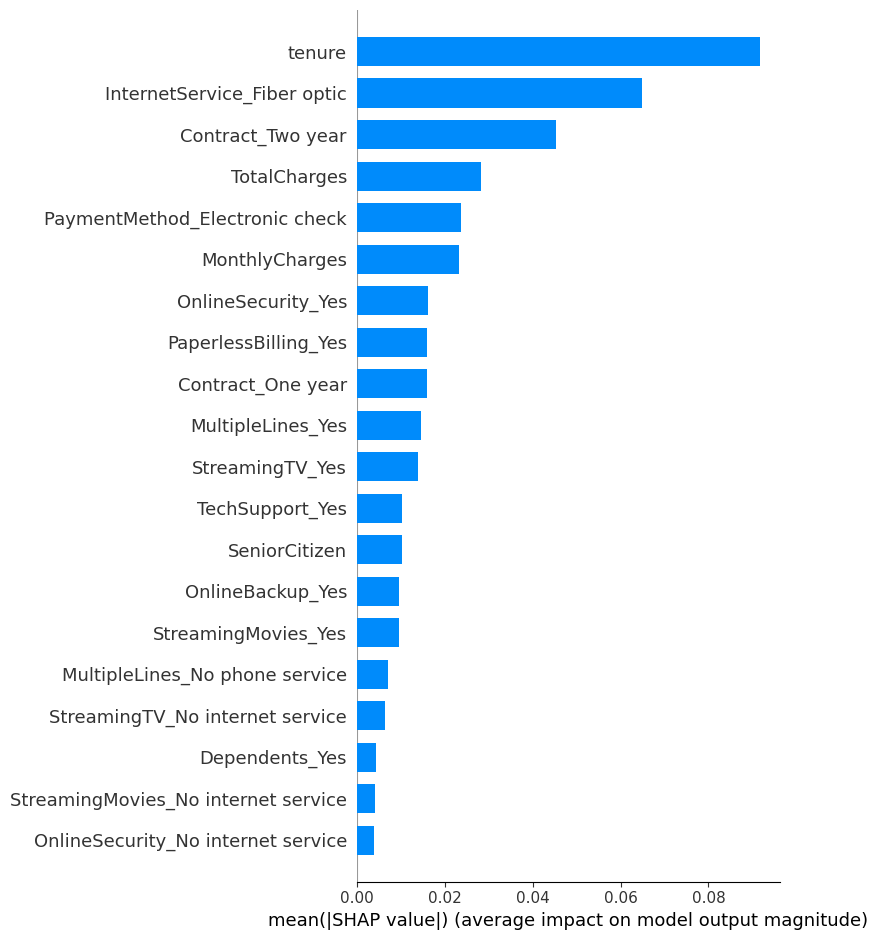

In [35]:
shap.summary_plot(
    shap_values=shap_values, 
    features=X_test, 
    plot_type='bar'
    )

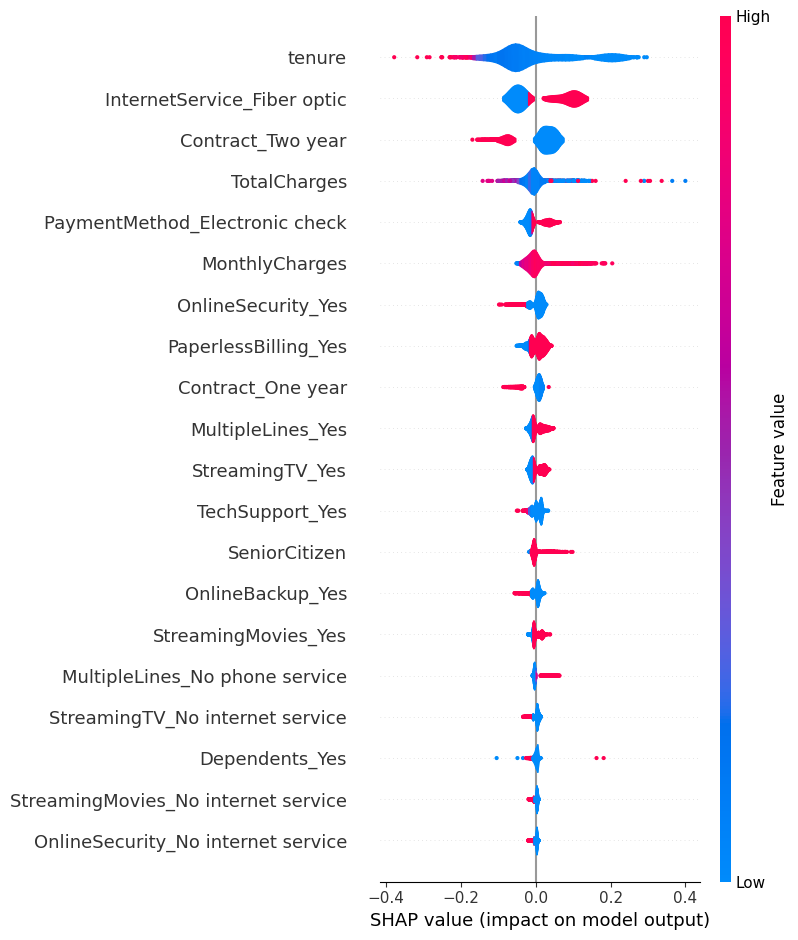

In [36]:
shap.summary_plot(
    shap_values=shap_values, 
    features=X_test, 
    plot_type='violin'
    )

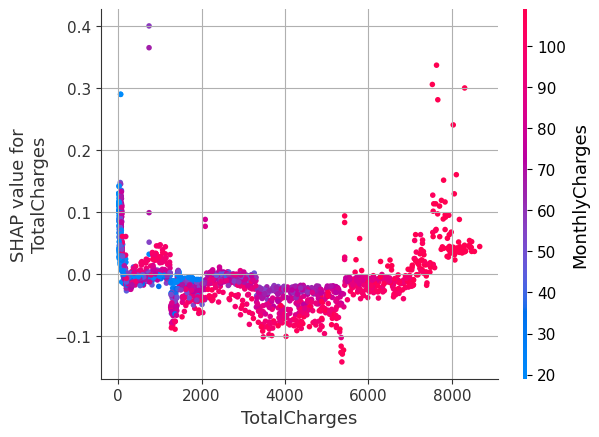

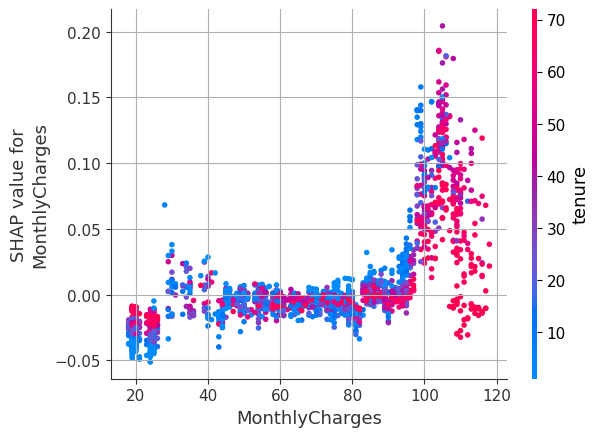

In [37]:
for f in data.numeric_features[:2]:
    fig, ax = plt.subplots(1,1)
    ax.grid()
    shap.dependence_plot(
        ind=f,
        shap_values=shap_values,
        features=X_test,
        interaction_index='auto',
        ax=ax
    )

# Survival Analysis
## Find best univariate model

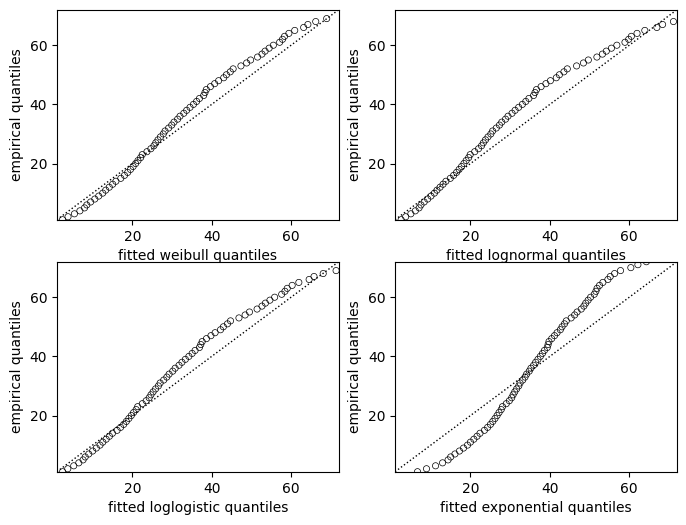

In [38]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes = axes.reshape(4,)

T = tenure_df_train['tenure']
E = tenure_df_train['Churn_Yes']

for i, model in enumerate([WeibullFitter(), LogNormalFitter(), LogLogisticFitter(), ExponentialFitter()]):
    model.fit(T, E)
    qq_plot(model, ax=axes[i])

## Training Weibull Model

In [39]:
import numpy as np
from lifelines import WeibullAFTFitter, CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.metrics import r2_score

class ChurnModels:
    def __init__(self):
        self.wb_aft_model = WeibullAFTFitter()
        self.cph_model = CoxPHFitter(penalizer=0.01)

    def fit(self, data:pd.DataFrame, duration_col:str, event_col:str, model_type:str):
        if model_type == 'WeibullAFT':
            self.wb_aft_model.fit(data, duration_col, event_col)
        elif model_type == 'CoxPH':
            self.cph_model.fit(data, duration_col, event_col)
        else:
            pass
    
    def summary(self, model_type:str):
        if model_type == 'WeibullAFT':
            return self.wb_aft_model.summary
        elif model_type == 'CoxPH':
            return self.cph_model.summary
        else:
            pass

    def predict_expected_lifetime(self, data:pd.DataFrame, model_type:str):
        if model_type == 'WeibullAFT':
            return self.wb_aft_model.predict_expectation(data)
        elif model_type == 'CoxPH':
            return self.cph_model.predict_expectation(data.drop(['tenure', 'Churn_Yes'], axis=1))
        else:
            pass
    
    def eval_concordance_index(self, event_times:pd.Series, event_predictions:pd.Series):
        "the r2 score should be best evaluated on uncensored subset of the data"
        return np.round(concordance_index(event_times, event_predictions), 2)
    
    def eval_r2_score(self, event_times:pd.Series, event_predictions:pd.Series):
        "the r2 score should be best evaluated on uncensored subset of the data"
        return np.round(r2_score(event_times, event_predictions), 2)

    


In [40]:
# initialize model
models = ChurnModels()

# fit Weibull-ATF model on all i.e. right-censored data
models.fit(
    data=tenure_df_train, 
    duration_col='tenure', 
    event_col='Churn_Yes',
    model_type='WeibullAFT')

# fit CoxPH model on all i.e. right-censored data
models.fit(
    data=tenure_df_train, 
    duration_col='tenure', 
    event_col='Churn_Yes',
    model_type='CoxPH')

The diagonal of the variance_matrix_ has negative values. This could be a problem with WeibullAFTFitter's fit to the data.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too.



In [41]:
# evaluate the models´ performance on uncensored data only
uncensored_data_train = tenure_df_train[tenure_df_train['Churn_Yes'] == 1]
uncensored_data_test = tenure_df_test[tenure_df_test['Churn_Yes'] == 1]

In [42]:
# Weibull Model: predict lifetimes on train and test sets
pred_train = models.predict_expected_lifetime(data=uncensored_data_train, model_type='WeibullAFT')
pred_test = models.predict_expected_lifetime(data=uncensored_data_test, model_type='WeibullAFT')

In [43]:
# Weibull Model: get concordance score on test set for the weibull model
cindex_train = models.eval_concordance_index(uncensored_data_train['tenure'], pred_train)
cindex_test = models.eval_concordance_index(uncensored_data_test['tenure'], pred_test)

print('Concordance index: train=', cindex_train)
print('Concordance index: test=', cindex_test)

Concordance index: train= 0.83
Concordance index: test= 0.82


In [44]:
# Weibull Model: get r2 score on test set for the weibull model
r2score_train = models.eval_r2_score(uncensored_data_train['tenure'], pred_train)
r2score_test = models.eval_r2_score(uncensored_data_test['tenure'], pred_test)

print('R2-score: train=', r2score_train)
print('R2-score: test=', r2score_test)

R2-score: train= -736.13
R2-score: test= -708.84


In [45]:
# Weibull Model: get summary statistics
models.summary(model_type='WeibullAFT')

coef   exp(coef)  \
param   covariate                                                     
lambda_ Contract_One year                      0.478916    1.614324   
        Contract_Two year                      1.066806    2.906083   
        Dependents_Yes                         0.083372    1.086947   
        DeviceProtection_No internet service   0.200996    1.222620   
        DeviceProtection_Yes                  -0.048591    0.952570   
        InternetService_Fiber optic           -0.816647    0.441911   
        InternetService_No                     0.200996    1.222620   
        MonthlyCharges                         0.003583    1.003589   
        MultipleLines_No phone service        -2.100711    0.122369   
        MultipleLines_Yes                     -0.053157    0.948231   
        OnlineBackup_No internet service       0.200996    1.222620   
        OnlineBackup_Yes                       0.024493    1.024795   
        OnlineSecurity_No internet service     0.200996    1.222620   
        OnlineSecurity_Yes                     0.204582    1.227012   
        PaperlessBilling_Yes                  -0.103590    0.901595   
        Partner_Yes                            0.143502    1.154309   
        PaymentMethod_Credit card (automatic)  0.069386    1.071850   
        PaymentMethod_Electronic check        -0.229543    0.794897   
        PaymentMethod_Mailed check            -0.250642    0.778301   
        PhoneService_Yes                      -2.440119    0.087151   
        SeniorCitizen                         -0.046271    0.954783   
        StreamingMovies_No internet service    0.200996    1.222620   
        StreamingMovies_Yes                   -0.175502    0.839036   
        StreamingTV_No internet service        0.200996    1.222620   
        StreamingTV_Yes                       -0.237769    0.788385   
        TechSupport_No internet service        0.200996    1.222620   
        TechSupport_Yes                        0.103327    1.108853   
        TotalCharges                           0.000728    1.000729   
        gender_Male                           -0.013625    0.986468   
        Intercept                              5.038904  154.300744   
rho_    Intercept                              0.357842    1.430240   

                                                   se(coef)  coef lower 95%  \
param   covariate                                                             
lambda_ Contract_One year                      2.163739e+10   -4.240850e+10   
        Contract_Two year                               NaN             NaN   
        Dependents_Yes                         6.476406e+11   -1.269352e+12   
        DeviceProtection_No internet service            NaN             NaN   
        DeviceProtection_Yes                            NaN             NaN   
        InternetService_Fiber optic                     NaN             NaN   
        InternetService_No                              NaN             NaN   
        MonthlyCharges                                  NaN             NaN   
        MultipleLines_No phone service                  NaN             NaN   
        MultipleLines_Yes                      4.232267e+06   -8.295091e+06   
        OnlineBackup_No internet service                NaN             NaN   
        OnlineBackup_Yes                       8.605118e-02   -1.441644e-01   
        OnlineSecurity_No internet service              NaN             NaN   
        OnlineSecurity_Yes                     1.186985e-01   -2.806316e-02   
        PaperlessBilling_Yes                            NaN             NaN   
        Partner_Yes                                     NaN             NaN   
        PaymentMethod_Credit card (automatic)  6.648192e-02   -6.091618e-02   
        PaymentMethod_Electronic check         1.124000e-01   -4.498432e-01   
        PaymentMethod_Mailed check                      NaN             NaN   
        PhoneService_Yes                       2

In [46]:
# CoxPh Model: predict lifetimes on train and test sets
pred_train = models.predict_expected_lifetime(data=uncensored_data_train, model_type='CoxPh')
pred_test = models.predict_expected_lifetime(data=uncensored_data_test, model_type='CoxPh')

In [47]:
pred_train

In [49]:
models.eval_concordance_index(uncensored_data_train['tenure'], pred_train)

ValueError: Event times and predictions must have the same shape

In [184]:
# CoxPh Model: get concordance score on test set for the weibull model
cindex_train = models.eval_concordance_index(uncensored_data_train['tenure'], pred_train)
cindex_test = models.eval_concordance_index(uncensored_data_test['tenure'], pred_test)

print('Concordance index: train=', cindex_train)
print('Concordance index: test=', cindex_test)

ValueError: Event times and predictions must have the same shape

In [47]:
# CoxPh Model: get summary statistics
models.summary(model_type='CoxPH')

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
SeniorCitizen,0.059594,1.061405,0.068128,-0.073936,0.193123,0.928732,1.213031,0.0,0.874725,3.817238e-01,1.389399
MonthlyCharges,0.008286,1.008320,0.004256,-0.000055,0.016627,0.999945,1.016766,0.0,1.947022,5.153212e-02,4.278384
TotalCharges,-0.001086,0.998914,0.000035,-0.001154,-0.001019,0.998847,0.998982,0.0,-31.440274,5.701155e-217,718.347142
gender_Male,0.008678,1.008715,0.056256,-0.101582,0.118938,0.903407,1.126300,0.0,0.154251,8.774116e-01,0.188674
Partner_Yes,-0.285068,0.751963,0.066196,-0.414810,-0.155326,0.660466,0.856136,0.0,-4.306412,1.659241e-05,15.879117
Dependents_Yes,-0.080636,0.922529,0.082878,-0.243074,0.081802,0.784213,1.085241,0.0,-0.972947,3.305794e-01,1.596931
PhoneService_Yes,0.271360,1.311747,0.355967,-0.426323,0.969043,0.652905,2.635420,0.0,0.762317,4.458708e-01,1.165302
MultipleLines_No phone service,-0.271360,0.762342,0.355967,-0.969043,0.426323,0.379446,1.531615,0.0,-0.762317,4.458708e-01,1.165302
MultipleLines_Yes,0.012181,1.012256,0.065946,-0.117070,0.141432,0.889523,1.151922,0.0,0.184715,8.534525e-01,0.228617


In [46]:
aft.plot_partial_effects_on_outcome(
    covariates='gender_Male',
    values=[0, 1]
)
plt.title('Survival Curve')
plt.grid()
plt.show()

NameError: name 'aft' is not defined

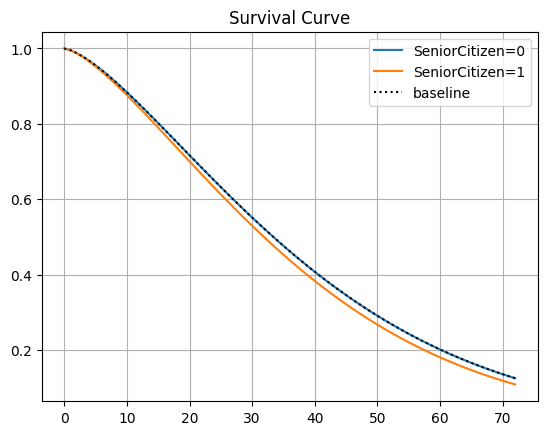

In [ ]:
aft.plot_partial_effects_on_outcome(
    covariates='SeniorCitizen',
    values=[0, 1]
)
plt.title('Survival Curve')
plt.grid()
plt.show()

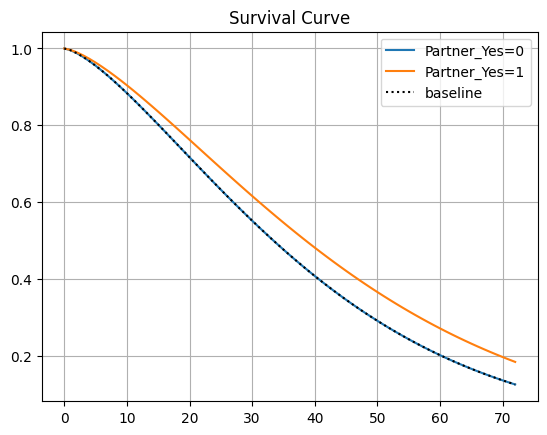

In [ ]:
aft.plot_partial_effects_on_outcome(
    covariates='Partner_Yes',
    values=[0, 1]
)
plt.title('Survival Curve')
plt.grid()
plt.show()

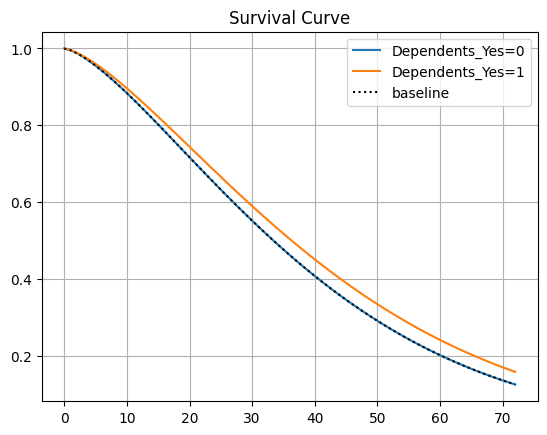

In [ ]:
aft.plot_partial_effects_on_outcome(
    covariates='Dependents_Yes',
    values=[0, 1]
)
plt.title('Survival Curve')
plt.grid()
plt.show()

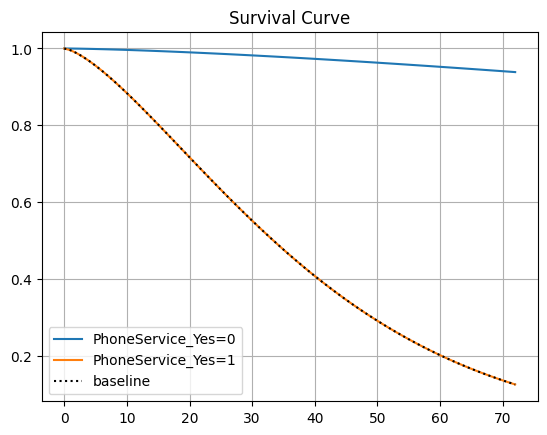

In [ ]:
aft.plot_partial_effects_on_outcome(
    covariates='PhoneService_Yes',
    values=[0, 1]
)
plt.title('Survival Curve')
plt.grid()
plt.show()

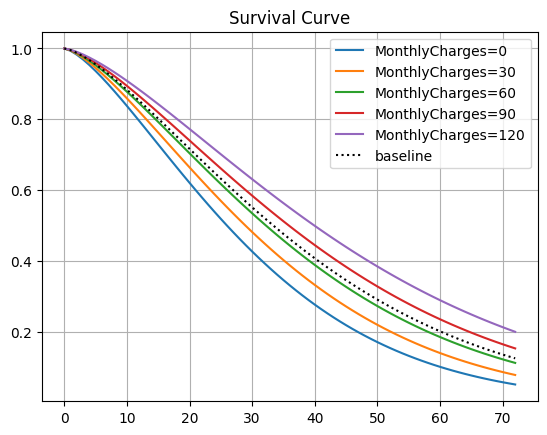

In [ ]:
aft.plot_partial_effects_on_outcome(
    covariates='MonthlyCharges',
    values=np.arange(0, 150, 30)
)
plt.title('Survival Curve')
plt.grid()
plt.show()

## Training Cox Proportional Hazard Model

In [199]:
coxph = CoxPHFitter(penalizer=.01)
#coxph = CoxPHFitter(penalizer=0)

In [200]:
coxph.fit(
    df=tenure_df_train, 
    duration_col='tenure', 
    event_col='Churn_Yes',
    robust=False)

<lifelines.CoxPHFitter: fitted with 4718 total observations, 3491 right-censored observations>

In [201]:
coxph.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
SeniorCitizen,0.059594,1.061405,0.068128,-0.073936,0.193123,0.928732,1.213031,0.0,0.874725,3.817238e-01,1.389399
MonthlyCharges,0.008286,1.008320,0.004256,-0.000055,0.016627,0.999945,1.016766,0.0,1.947022,5.153212e-02,4.278384
TotalCharges,-0.001086,0.998914,0.000035,-0.001154,-0.001019,0.998847,0.998982,0.0,-31.440274,5.701155e-217,718.347142
gender_Male,0.008678,1.008715,0.056256,-0.101582,0.118938,0.903407,1.126300,0.0,0.154251,8.774116e-01,0.188674
Partner_Yes,-0.285068,0.751963,0.066196,-0.414810,-0.155326,0.660466,0.856136,0.0,-4.306412,1.659241e-05,15.879117
Dependents_Yes,-0.080636,0.922529,0.082878,-0.243074,0.081802,0.784213,1.085241,0.0,-0.972947,3.305794e-01,1.596931
PhoneService_Yes,0.271360,1.311747,0.355967,-0.426323,0.969043,0.652905,2.635420,0.0,0.762317,4.458708e-01,1.165302
MultipleLines_No phone service,-0.271360,0.762342,0.355967,-0.969043,0.426323,0.379446,1.531615,0.0,-0.762317,4.458708e-01,1.165302
MultipleLines_Yes,0.012181,1.012256,0.065946,-0.117070,0.141432,0.889523,1.151922,0.0,0.184715,8.534525e-01,0.228617


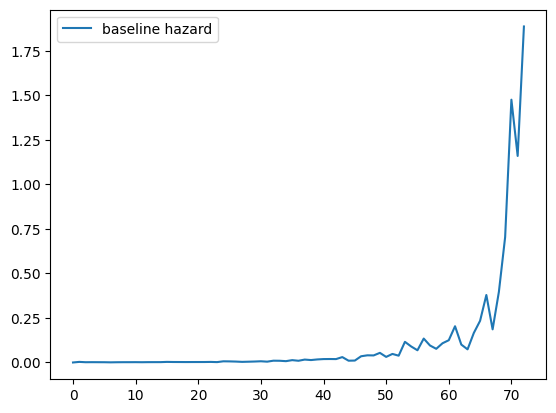

In [325]:
coxph.baseline_hazard_.plot()
plt.show()

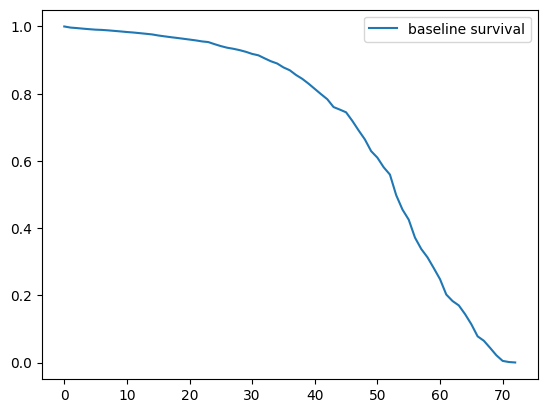

In [ ]:
coxph.baseline_survival_.plot()
plt.show()


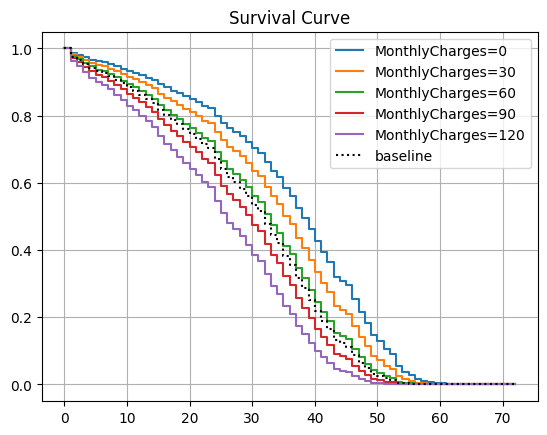

In [ ]:
coxph.plot_partial_effects_on_outcome(
    covariates='MonthlyCharges',
    values=np.arange(0, 150, 30)
)
plt.title('Survival Curve')
plt.grid()
plt.show()

# Predict on Test Data

In [ ]:
tenure_df_test.head(3)

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes
941,0,13.001,30,382,0,0,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1404,0,35.001,23,797,0,0,0,1,0,1,...,0,1,0,0,1,0,0,0,0,0
5515,0,18.001,19,309,0,1,1,1,0,0,...,0,1,0,0,1,0,0,0,1,0


In [202]:
has_churned = tenure_df_test[tenure_df_test['Churn_Yes'] == 1]
has_churned.head(3)

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes
5069,0,4.001,75,338,0,0,0,1,0,1,...,0,0,0,0,0,0,0,1,0,1
5799,0,13.001,35,446,0,0,0,0,1,0,...,0,0,1,0,0,1,0,1,0,1
6509,1,1.001,25,25,1,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,1


In [203]:
not_churned = tenure_df_test[tenure_df_test['Churn_Yes'] == 0]
not_churned.head(3)

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes
941,0,13.001,30,382,0,0,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1404,0,35.001,23,797,0,0,0,1,0,1,...,0,1,0,0,1,0,0,0,0,0
5515,0,18.001,19,309,0,1,1,1,0,0,...,0,1,0,0,1,0,0,0,1,0


In [204]:
feat = list(has_churned.columns)
feat.remove('Churn_Yes')
feat.remove('tenure')
feat

['SeniorCitizen',
 'MonthlyCharges',
 'TotalCharges',
 'gender_Male',
 'Partner_Yes',
 'Dependents_Yes',
 'PhoneService_Yes',
 'MultipleLines_No phone service',
 'MultipleLines_Yes',
 'InternetService_Fiber optic',
 'InternetService_No',
 'OnlineSecurity_No internet service',
 'OnlineSecurity_Yes',
 'OnlineBackup_No internet service',
 'OnlineBackup_Yes',
 'DeviceProtection_No internet service',
 'DeviceProtection_Yes',
 'TechSupport_No internet service',
 'TechSupport_Yes',
 'StreamingTV_No internet service',
 'StreamingTV_Yes',
 'StreamingMovies_No internet service',
 'StreamingMovies_Yes',
 'Contract_One year',
 'Contract_Two year',
 'PaperlessBilling_Yes',
 'PaymentMethod_Credit card (automatic)',
 'PaymentMethod_Electronic check',
 'PaymentMethod_Mailed check']

In [330]:
# predict tenure using Cox Proportional Hazard Model
pred_CPH = coxph.predict_median(
    X = has_churned[feat],
    conditional_after = None
    )

pred_CPH

5069     5.001
5799    22.001
6509    24.001
3499    41.001
3994    72.001
         ...  
2485    11.001
1478    48.001
6626     4.001
5198    54.001
4544     3.001
Name: 0.5, Length: 642, dtype: float64

In [ ]:
has_churned['tenure_prediction_WB'] = pred_WB
has_churned['tenure_prediction_CPH'] = pred_CPH


# replace the inf values of the coxprop model predictions with the max values
max_tennure_pred = has_churned['tenure_prediction_CPH'][has_churned['tenure_prediction_CPH'] != np.inf].max()
has_churned['tenure_prediction_CPH'].replace([np.inf, -np.inf], max_tennure_pred, inplace=True)

has_churned.head(10)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes,tenure_prediction_WB,tenure_prediction_CPH
5069,0,4.001,75,338,0,0,0,1,0,1,...,0,0,0,0,0,1,0,1,5.801404,5.001
5799,0,13.001,35,446,0,0,0,0,1,0,...,1,0,0,1,0,1,0,1,13.784992,22.001
6509,1,1.001,25,25,1,1,0,0,1,0,...,0,0,0,0,0,1,0,1,14.066225,24.001
3499,0,1.001,20,20,0,0,0,1,0,0,...,0,0,0,0,0,0,1,1,36.056256,41.001
3994,1,54.001,101,5373,0,1,0,1,0,1,...,1,1,0,1,1,0,0,1,365.649129,72.001
2018,0,1.001,45,45,0,0,0,1,0,0,...,0,0,0,1,0,0,1,1,8.866660,11.001
1577,0,17.001,98,1704,0,1,1,1,0,0,...,1,1,0,0,0,0,0,1,31.992856,37.001
2862,0,7.001,69,451,1,1,0,1,0,0,...,0,0,0,1,0,1,0,1,6.674949,8.001
4488,1,42.001,74,3229,0,1,0,1,0,0,...,0,0,0,1,1,0,0,1,82.331726,52.001
3408,0,4.001,50,151,0,0,0,1,0,0,...,0,0,0,0,1,0,0,1,15.264618,22.001


-509.32835545678745

In [ ]:
# get r2 score on test set for the Cox Proportional Model
r2_score(has_churned['tenure'], has_churned['tenure_prediction_CPH'])

0.4727671442715552

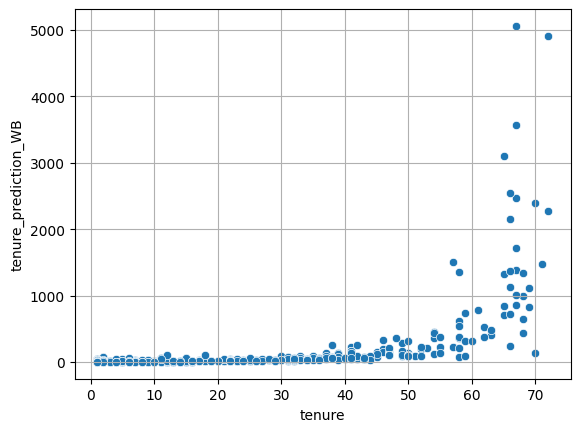

In [ ]:
sns.scatterplot(
    data=has_churned,
    x='tenure',
    y='tenure_prediction_WB'
)
#plt.xlim(0,100)
#plt.ylim(0,100)
plt.grid()

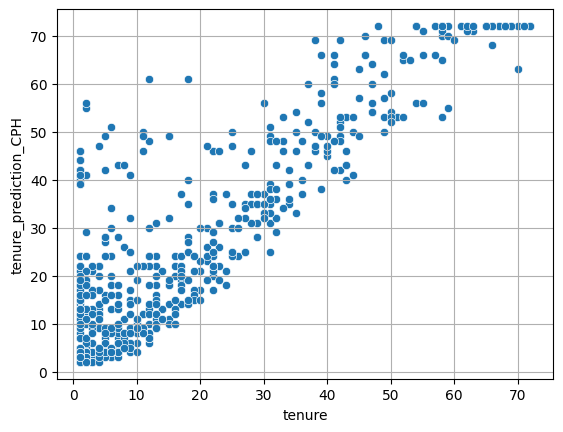

In [ ]:
sns.scatterplot(
    data=has_churned,
    x='tenure',
    y='tenure_prediction_CPH'
)
#plt.xlim(0,100)
#plt.ylim(0,100)
plt.grid()

# Survival Analysis using Scikit-Survival Package

In [ ]:
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.util import Surv

In [ ]:
features = tenure_df_train.columns.to_list()
features.remove('tenure')
#features.remove('TotalCharges')
features.remove('Churn_Yes')
features

['SeniorCitizen',
 'MonthlyCharges',
 'TotalCharges',
 'gender_Male',
 'Partner_Yes',
 'Dependents_Yes',
 'PhoneService_Yes',
 'MultipleLines_No phone service',
 'MultipleLines_Yes',
 'InternetService_Fiber optic',
 'InternetService_No',
 'OnlineSecurity_No internet service',
 'OnlineSecurity_Yes',
 'OnlineBackup_No internet service',
 'OnlineBackup_Yes',
 'DeviceProtection_No internet service',
 'DeviceProtection_Yes',
 'TechSupport_No internet service',
 'TechSupport_Yes',
 'StreamingTV_No internet service',
 'StreamingTV_Yes',
 'StreamingMovies_No internet service',
 'StreamingMovies_Yes',
 'Contract_One year',
 'Contract_Two year',
 'PaperlessBilling_Yes',
 'PaymentMethod_Credit card (automatic)',
 'PaymentMethod_Electronic check',
 'PaymentMethod_Mailed check']

In [ ]:
X_train = tenure_df_train[features]
y_train = Surv.from_dataframe(
    event = 'Churn_Yes', 
    time = 'tenure', 
    data = tenure_df_train)

In [ ]:
X_test = tenure_df_test[features]
y_test = Surv.from_dataframe(
    event = 'Churn_Yes', 
    time = 'tenure', 
    data = tenure_df_test)

In [ ]:
estimator = GradientBoostingSurvivalAnalysis(loss="coxph")
estimator.fit(X_train, y_train)

GradientBoostingSurvivalAnalysis()

In [ ]:
# estimate the accuracy of the model i.e. the concordinance score
estimator.score(X_train, y_train)

0.9668742872159453

In [ ]:
estimator.score(X_test, y_test)

0.9607266328620302

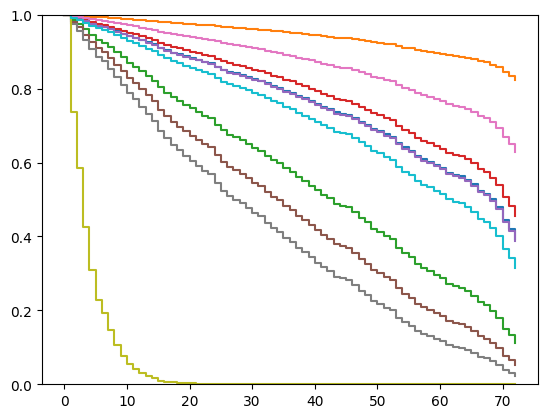

In [ ]:
surv_funcs = estimator.predict_survival_function(X_train.iloc[:10])
for fn in surv_funcs:
    plt.step(fn.x, fn(fn.x), where="post")

plt.ylim(0, 1)
plt.show()

## Predict Times to Event

In [ ]:
# predict tenure times
estimator = GradientBoostingSurvivalAnalysis(loss="squared")
estimator.fit(X_train, y_train) 


GradientBoostingSurvivalAnalysis(loss='squared')

In [ ]:
estimator.score(X_train, y_train)

0.9863267571279677

In [ ]:
estimator.score(X_test, y_test)

0.983501222131694

In [ ]:
time_to_event_pred = estimator.predict(X_test)

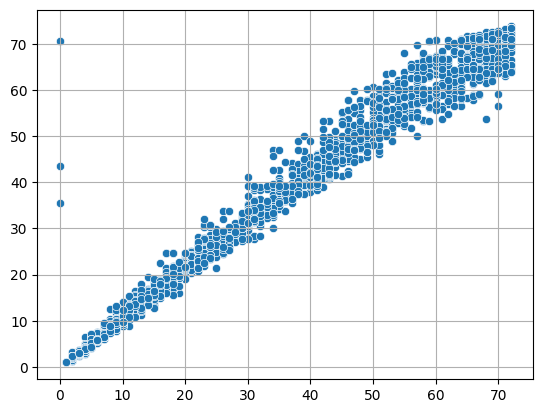

In [ ]:
sns.scatterplot(
    x=[tte for event, tte in y_test],
    y=time_to_event_pred
)
#plt.xlim(0,100)
#plt.ylim(0,100)
plt.grid()

In [ ]:
# let´s just predict time-to-event on the uncensored dataset
index_uncensored = [i for i in range(len(y_test)) if y_test[i][0] == True]

In [ ]:
X_test.iloc[index_uncensored]

,SeniorCitizen,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
5069,0,75,338,0,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,1,0
5799,0,35,446,0,0,0,0,1,0,0,...,0,0,0,1,0,0,1,0,1,0
6509,1,25,25,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3499,0,20,20,0,0,0,1,0,0,0,...,1,0,1,0,0,0,0,0,0,1
3994,1,101,5373,0,1,0,1,0,1,1,...,0,1,0,1,1,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2485,0,80,1072,0,0,0,1,0,1,1,...,0,0,0,0,0,0,1,0,1,0
1478,0,104,4346,1,0,0,1,0,1,1,...,0,1,0,1,0,0,1,0,1,0
6626,1,95,573,1,1,0,1,0,0,1,...,0,1,0,1,0,0,1,0,1,0
5198,1,80,3825,0,1,0,1,0,1,1,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
y_test[index_uncensored]

array([( True,  4.001), ( True, 13.001), ( True,  1.001), ( True,  1.001),
       ( True, 54.001), ( True,  1.001), ( True, 17.001), ( True,  7.001),
       ( True, 42.001), ( True,  4.001), ( True,  1.001), ( True, 39.001),
       ( True, 59.001), ( True, 32.001), ( True, 24.001), ( True,  1.001),
       ( True, 40.001), ( True,  6.001), ( True,  1.001), ( True, 10.001),
       ( True, 30.001), ( True,  4.001), ( True,  1.001), ( True,  5.001),
       ( True,  4.001), ( True, 69.001), ( True,  1.001), ( True, 65.001),
       ( True, 34.001), ( True,  1.001), ( True,  1.001), ( True, 72.001),
       ( True, 52.001), ( True,  9.001), ( True,  2.001), ( True, 29.001),
       ( True, 13.001), ( True, 35.001), ( True, 23.001), ( True,  1.001),
       ( True, 54.001), ( True, 72.001), ( True,  8.001), ( True, 49.001),
       ( True,  1.001), ( True, 38.001), ( True,  3.001), ( True, 15.001),
       ( True, 46.001), ( True, 12.001), ( True, 14.001), ( True,  7.001),
       ( True, 58.001), (

In [ ]:
time_to_event_pred = estimator.predict(X_test.iloc[index_uncensored])

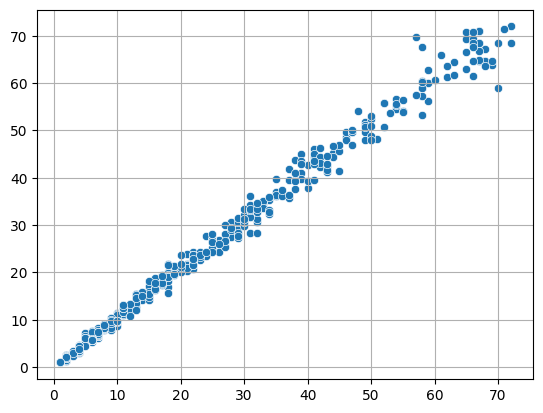

In [ ]:
sns.scatterplot(
    x=[tte for event, tte in y_test[index_uncensored]],
    y=time_to_event_pred
)
#plt.xlim(0,100)
#plt.ylim(0,100)
plt.grid()

## Predict Time To Event for every Point in Time

In [ ]:
staged_time_to_event_pred = np.array([tte for tte in estimator.staged_predict(X_test)])

In [ ]:
time_to_event_pred[4]

54.44538191574153

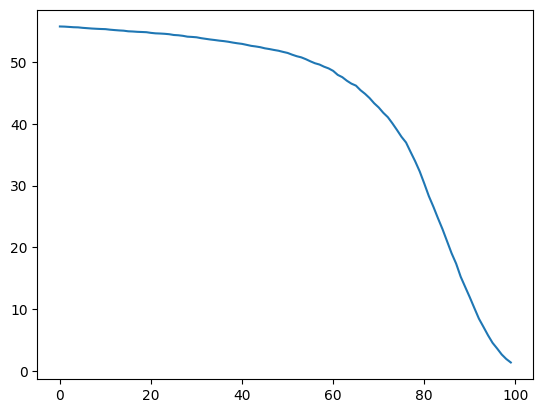

In [ ]:
plt.plot(staged_time_to_event_pred[::-1,4])

# To Do

In [ ]:
# use further covariates in order for the cox model to converge
# upload local git repo to github
# compare model to normal regression model